In [4]:

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [5]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [6]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 13194 files belonging to 4 classes.


In [7]:
class_names = dataset.class_names
class_names

['Grape Black Measles',
 'Grape Black rot',
 'Grape Healthy',
 'Grape Isariopsis Leaf Spot']

In [8]:
len(dataset)

413

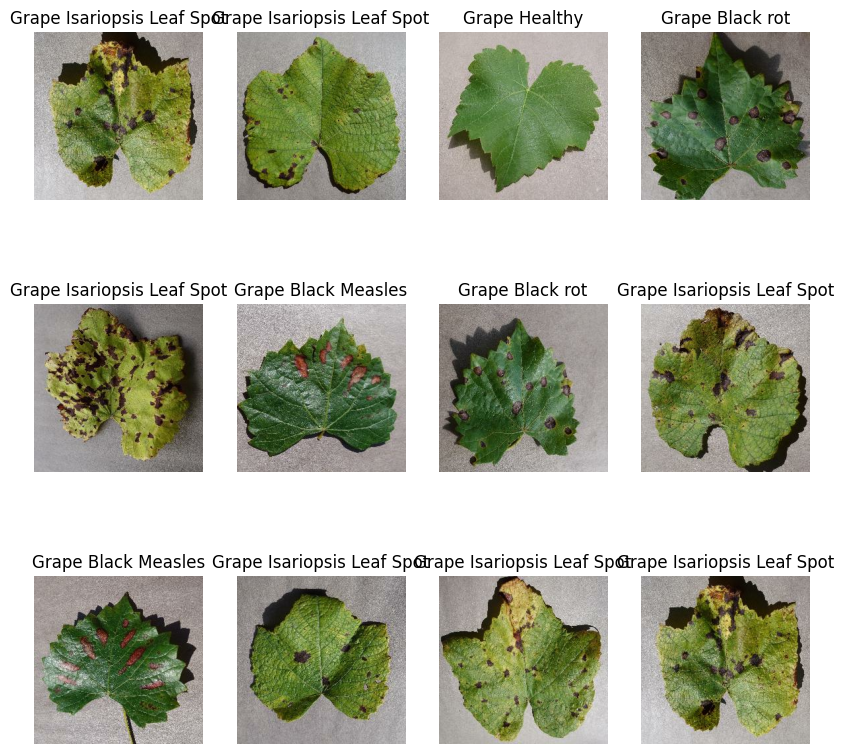

In [9]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(class_names[labels_batch[0]])
    plt.axis("off")
    

In [10]:
len(dataset)

413

In [11]:
train_percentage = 80  # 80% entrenamiento
validation_percentage = 10  # 10% validación
test_percentage = 10  # 10% prueba

In [12]:
train_size = 0.8
len(dataset) * train_size

330.40000000000003

In [13]:
train_ds = dataset.take(81)
len(train_ds)

81

In [14]:
test_ds = dataset.skip(81)
len(test_ds) 

332

In [15]:
val_size = 0.1
len(test_ds) * val_size

33.2

In [16]:
val_ds = test_ds.take(9)
len(val_ds)

9

In [17]:
test_ds = test_ds.skip(9)
len(test_ds)

323

In [18]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + val_split + test_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [19]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [20]:
len(train_ds), len(val_ds), len(test_ds)

(330, 41, 42)

In [21]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [22]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [23]:
data_argumentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

In [24]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4

model = models.Sequential([
    layers.Input(shape=input_shape),
    resize_and_rescale,
    data_argumentation,
    layers.Conv2D(32, (3,3), activation="relu", input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (3,3), activation="relu"),  
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (3,3), activation="relu"),  
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dense(n_classes, activation="softmax"),
])

c:\Users\candy\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [25]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 347,780 (1.33 MB)

 Trainable params: 347,780 (1.33 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

In [27]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds,
    callbacks=[early_stopping]

)


Epoch 1/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 391s 1s/step - accuracy: 0.5240 - loss: 1.0093 - val_accuracy: 0.7873 - val_loss: 0.5188
Epoch 2/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 290s 875ms/step - accuracy: 0.8975 - loss: 0.2905 - val_accuracy: 0.9398 - val_loss: 0.1695
Epoch 3/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 258s 781ms/step - accuracy: 0.9470 - loss: 0.1669 - val_accuracy: 0.9581 - val_loss: 0.1398
Epoch 4/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 269s 815ms/step - accuracy: 0.9562 - loss: 0.1334 - val_accuracy: 0.9688 - val_loss: 0.1036
Epoch 5/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 261s 791ms/step - accuracy: 0.9729 - loss: 0.0891 - val_accuracy: 0.9619 - val_loss: 0.0877
Epoch 6/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 241s 732ms/step - accuracy: 0.9713 - loss: 0.0875 - val_accuracy: 0.9680 - val_loss: 0.0963
Epoch 7/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 249s 754ms/step - accuracy: 0.9761 - loss: 0.0686 - val_accuracy: 0.9642 - val_loss: 0.0882
Epoch 8/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 245s 744ms/step - accuracy: 0.9806 - lo

In [32]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [33]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

Text(0.5, 1.0, 'Training and Validation Accuracy')

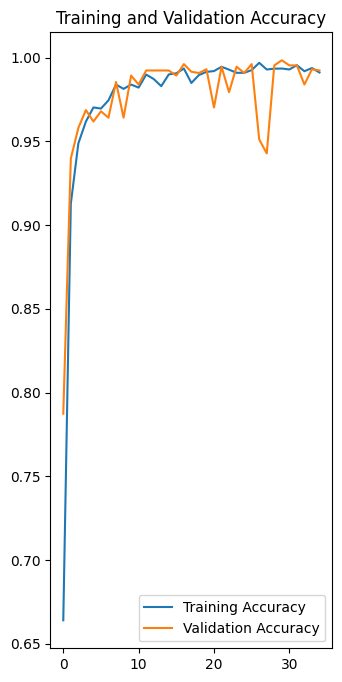

In [34]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
epochs_range = range(len(acc))  # Adjust range to match the length of accuracy lists
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

Primera imagen para predecir
Etiqueta Actual: Grape Isariopsis Leaf Spot
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
Predicciones del modelo: Grape Isariopsis Leaf Spot


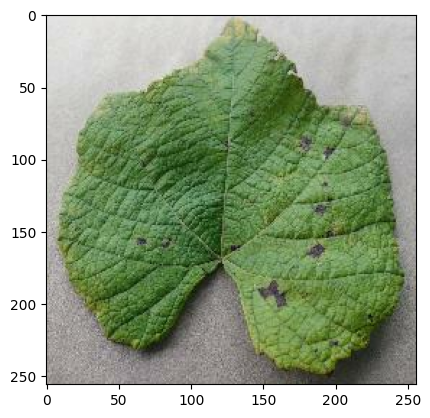

In [42]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype("uint8")
    first_label = labels_batch[0].numpy()
    print("Primera imagen para predecir")
    plt.imshow(first_image)
    print("Etiqueta Actual:", class_names[first_label])
    batch_prediction = model.predict(images_batch)
    print("Predicciones del modelo:", class_names[np.argmax(batch_prediction[0])])

In [36]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)
    
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [1]:
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f"Actual: {actual_class}, \n Enfermedad: {predicted_class}.\n Confidence:{confidence}%", fontsize=5)
        plt.axis("off")

NameError: name 'test_ds' is not defined

In [43]:
import os

model_version = 3
save_dir = r"C:\Users\candy\Documents\Python\PlantasEnf\modelo"  # Ruta especificada
os.makedirs(save_dir, exist_ok=True)  # Crear el directorio si no existe
model.save(os.path.join(save_dir, f"{model_version}.keras"))

In [39]:
import tensorflow as tf

# Imprimir la versión de TensorFlow
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.17.0
